In [ ]:
import os
import sys
sys.path.append("/home/user/Documents/GPO/general")
from _sdd import *
import gpytorch
from gpytorch.means import MultitaskMean
from gpytorch.kernels import InducingPointKernel, ScaleKernel
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.distributions import MultitaskMultivariateNormal
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from utilities3 import *
from pytorch_wavelets import DWT, IDWT
from pytorch_wavelets import DWT1D, IDWT1D
import scipy
from _sdd import *
from _sdd_pos_samples import *
from utils import *




# %%
'''  
DEVICE
'''
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(f"Device: {device}")

# torch.manual_seed(0)
# np.random.seed(0)

'''   
CONFIG AND DATA 
'''
ntrain = 1100
ntest = 200
# SDD parameters
lr = 0.1
momentum = 0.9
iterations = 10000
B = 32
polyak=1e-2
noise_scale=0.02
length_scale = 12.4 

sub = 2**4  
h = 2**13 // sub  
s = h

sub_hres = 2**3
h2 = 2**13 // sub_hres
s2 = h2


# loading the data
dataloader = MatReader(
   r"/home/user/Documents/GP_WNO/DATA/burgers_data_R10.mat")
x_data = dataloader.read_field("a")[:, ::sub]
y_data = dataloader.read_field("u")[:, ::sub]

#high resolution
x_data_hres = dataloader.read_field("a")[:, ::sub_hres]
y_data_hres = dataloader.read_field("u")[:, ::sub_hres]



x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)


# high resolution data
x_train_hres = x_data_hres[:ntrain,:]
y_train_hres = y_data_hres[:ntrain,:]
x_test_hres = x_data_hres[-ntest:,:]
y_test_hres = y_data_hres[-ntest:,:]

x_train_hres = x_train_hres.reshape(ntrain,s2,1)
x_test_hres = x_test_hres.reshape(ntest,s2,1)



x_tr = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
y_tr = y_train

# test data
x_t = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
y_t = y_test


x_tr=x_tr.to(device)
y_tr=y_tr.to(device)
x_t=x_t.to(device)
y_t=y_t.to(device)

# /mu_posterior

Kernel = ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)).to(device=device)
Kernel.base_kernel.lengthscale= length_scale
#Load y_pred_sdd
# y_pred_sdd = torch.load("/home/user/Documents/DKL/Burger/model"+'y_pred_sdd.pt')
# y_pred_sdd = torch.load("/home/user/Documents/DKL/Burger/model/y_pred_sdd_hres_12_6.pt").to(device)
# y_pred_sdd = torch.load("/home/user/Documents/DKL/Burger/y_pred_sdd_040724_1501.pt").to(device)
# nn_wno = WNO1d(width, level, x_train.permute(0,2,1)).to(device)

Device: cuda:0


In [11]:
y_pred_hres = np.load('results/SDD_sample_mean_predictions_hres_200824_0937.npy')
std_pred_hres = np.load('results/SDD_sample_variance_predictions_hres_200824_0937.npy')

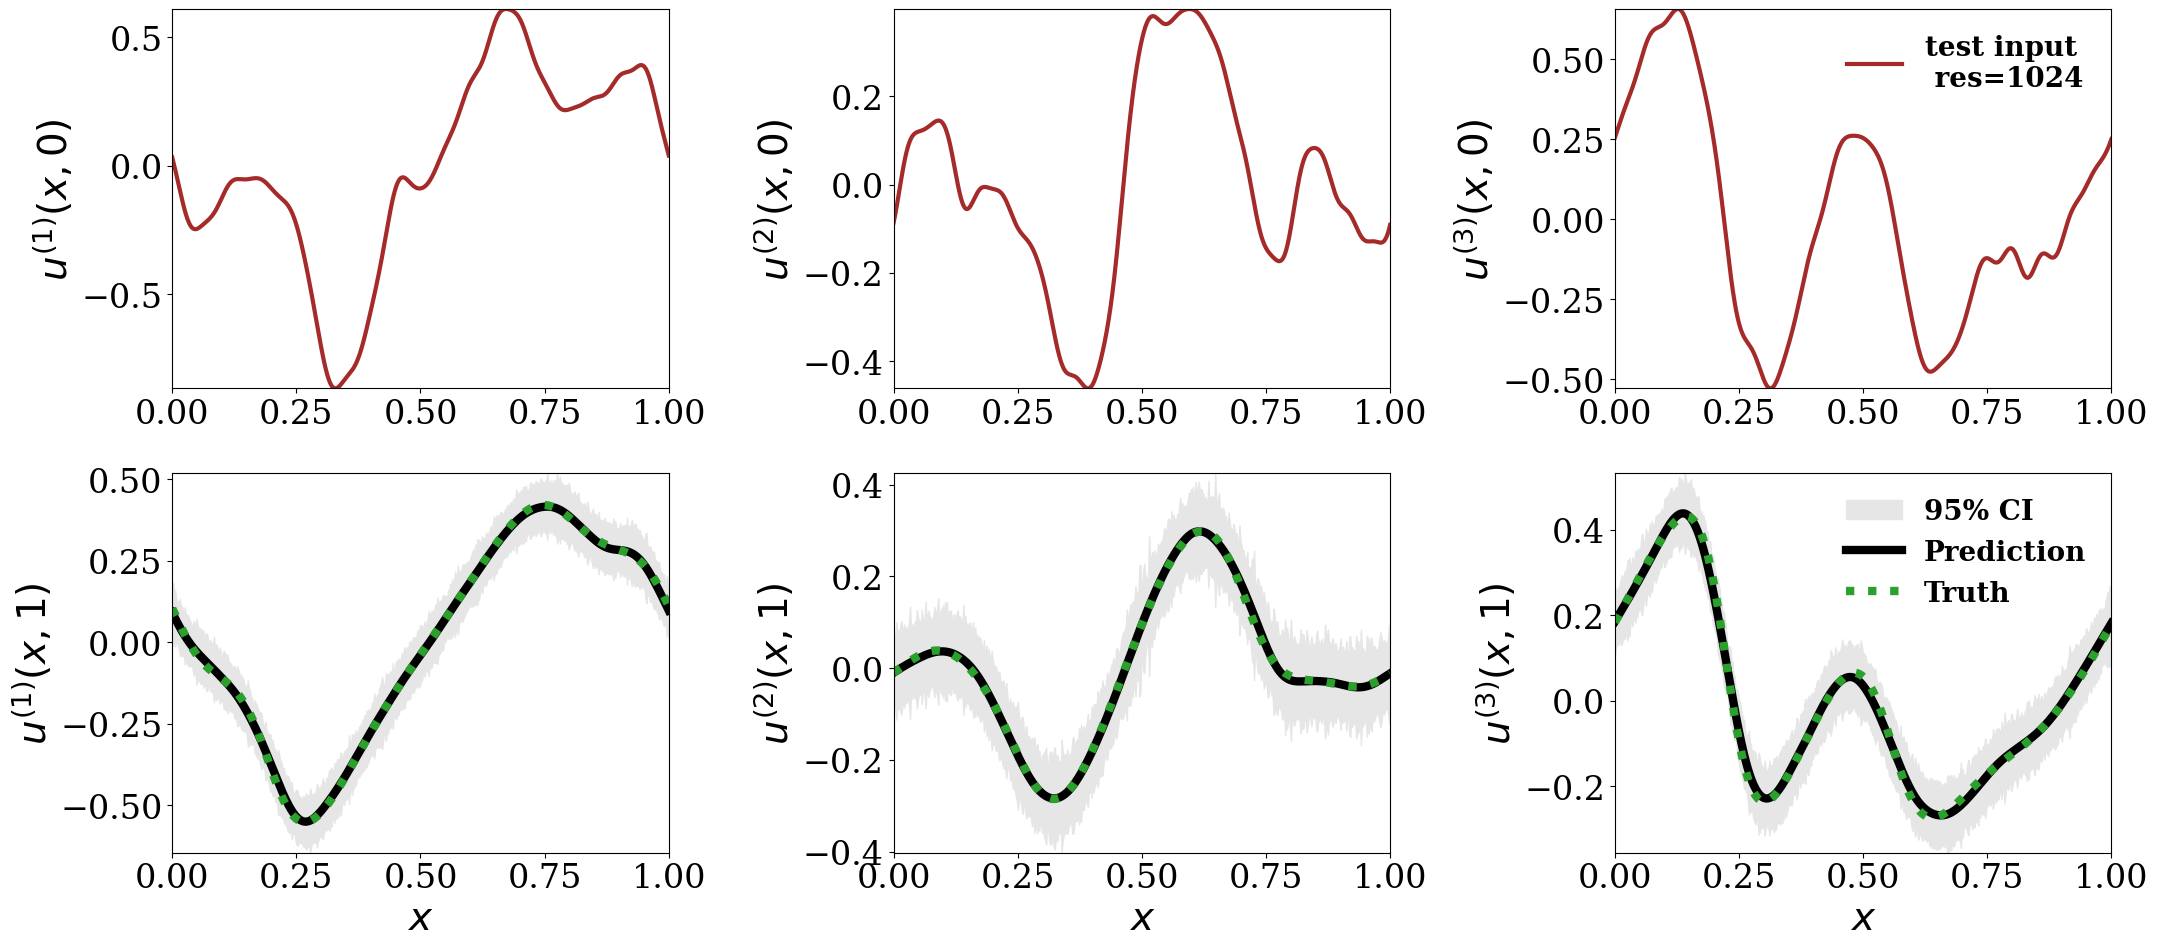

In [15]:
import numpy as np
import matplotlib.pyplot as plt


x_axis = np.linspace(0, 1, s)
x_axis = x_axis.flatten()

figure = plt.figure(figsize=(22, 10))  
plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 24

mean_pred = y_pred_hres
std = std_pred_hres*1.9
num_subplots = 3  

# First row: Plot initial condition
for subplot_idx in range(num_subplots):
    ax = figure.add_subplot(2, 3, subplot_idx + 1)  # First row (2 rows, 3 columns)
    
    i = subplot_idx + 2  # Set the value of i for each subplot
    
    ax.plot(np.linspace(0,1,1024).flatten(), x_test_hres.squeeze(-1).detach().cpu().numpy()[i, :], 
            label="test input \n res=1024", linewidth=3.0, c='brown')
    # ax.set_xlabel("x", fontsize=28)
    ax.set_ylabel(f"$u^{{({subplot_idx + 1})}}(x,0)$", fontsize=28)
    plt.margins(0)
    
    if subplot_idx == 2:
        ax.legend(frameon=False, loc='upper right', prop={'weight': 'bold', 'size': 20})

# Second row: Plot predictions with confidence intervals
for subplot_idx in range(num_subplots):
    ax = figure.add_subplot(2, 3, subplot_idx + 4)  # Second row (2 rows, 3 columns)
    
    i = subplot_idx + 2  # Set the value of i for each subplot
    
    ax.fill_between(
        x_axis,
        (mean_pred[i, :].reshape(-1, 1) - std[i, :].reshape(-1, 1)).flatten(),
        (mean_pred[i, :].reshape(-1, 1) + std[i, :].reshape(-1, 1)).flatten(),
        color=(0.9,) * 3, label='95% CI'
    )
    ax.plot(x_axis, y_pred_hres[i, :].reshape(-1, 1), label="Prediction", linewidth=6.0, c='black')
    ax.plot(x_axis, y_t.detach().cpu().numpy()[i, :], ":", label="Truth", linewidth=6.0, c='tab:green')
    ax.set_xlabel("$x$", fontsize=28)
    ax.set_ylabel(f"$u^{{({subplot_idx + 1})}}(x,1)$", fontsize=28)
    plt.margins(0)
    
    if subplot_idx == 2:
        ax.legend(frameon=False, loc='upper right', prop={'weight': 'bold', 'size': 20})

plt.tight_layout()  # Adjust the spacing between subplots
plt.savefig('/home/user/Documents/WaKeGP/experiments/C1_burger/results/super_burger_10_09.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()


In [16]:
y_pred_hres = np.load('results/SDD_sample_mean_predictions_200824_1903.npy')
std_pred_hres = np.load('results/SDD_sample_variance_predictions_200824_1903.npy')

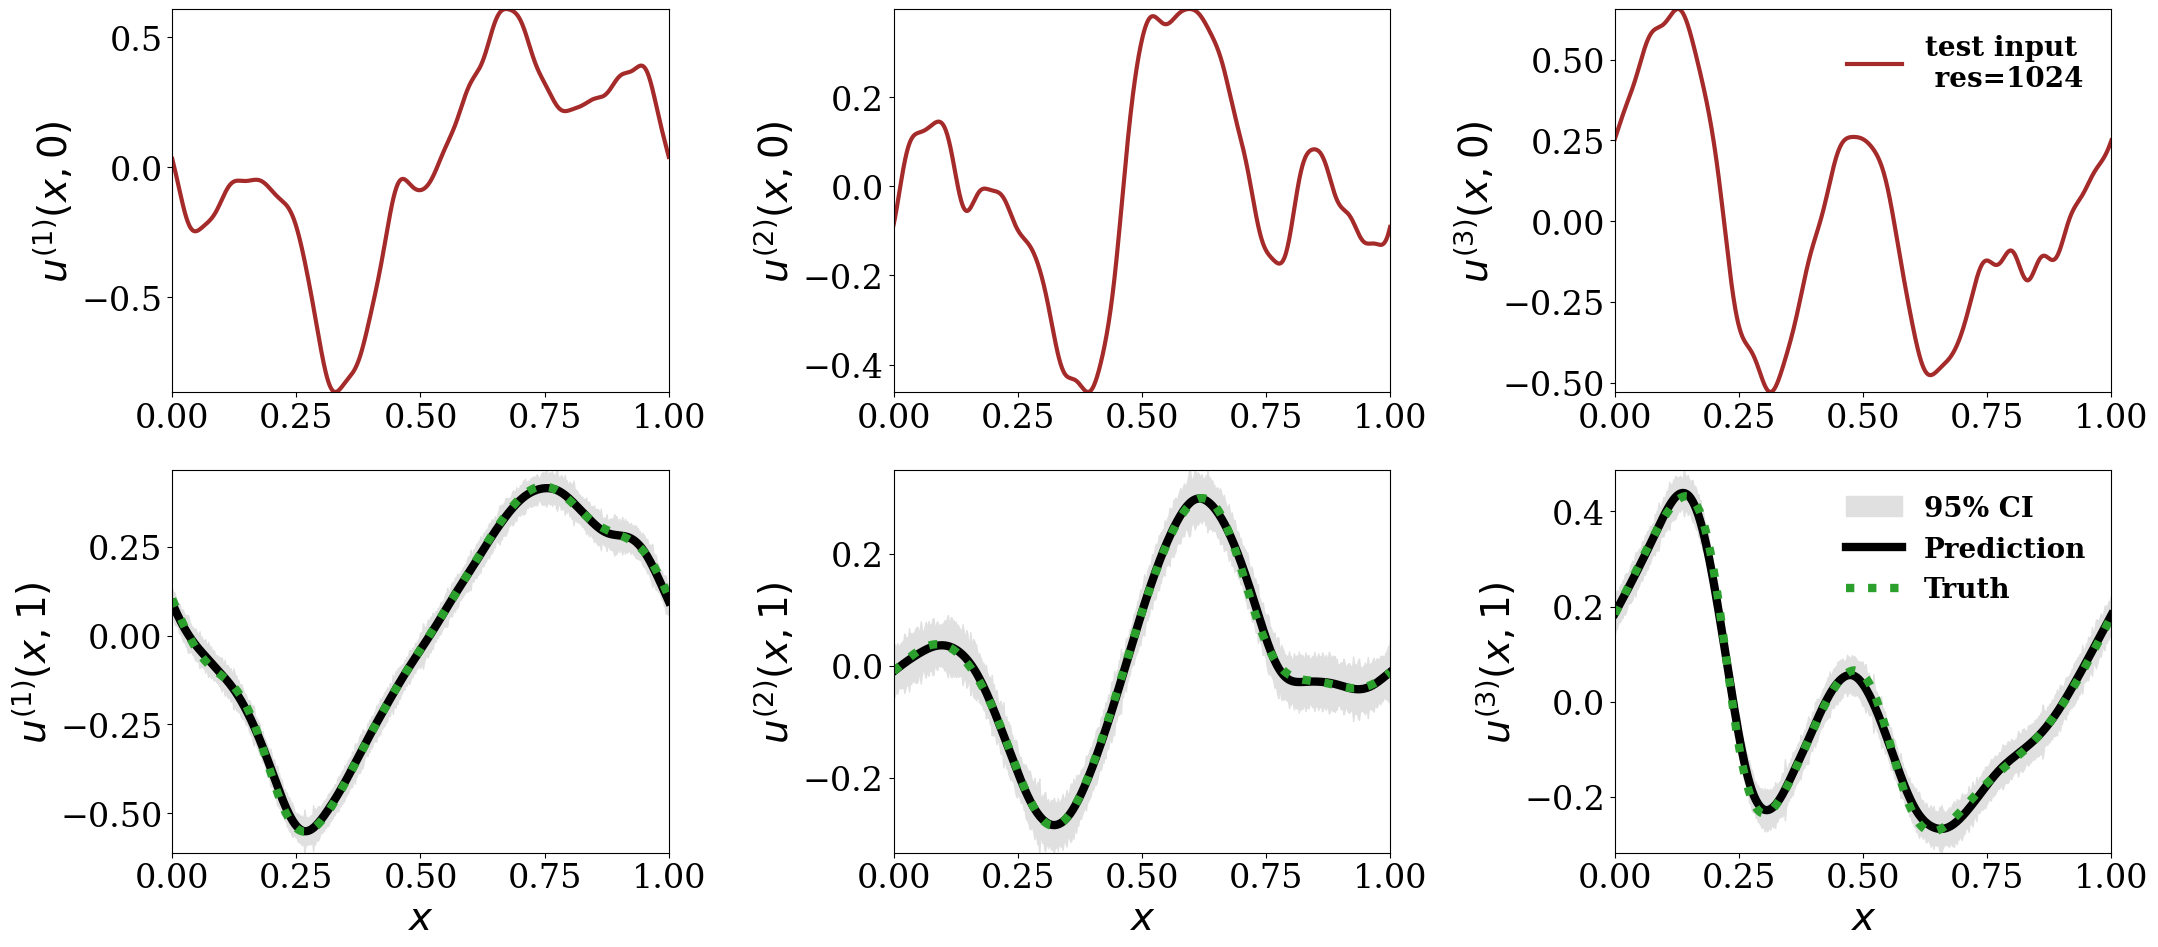

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming s, y_pred_sdd, std_pred, y_t, and x_t are already defined

x_axis = np.linspace(0, 1, s)
x_axis = x_axis.flatten()

# Create a figure with 2 rows and 3 columns
figure = plt.figure(figsize=(22, 10))  # Adjusted height to accommodate two rows of plots
plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 24

mean_pred = y_pred_hres
std = std_pred_hres*1.95
num_subplots = 3  

# First row: Plot initial condition
for subplot_idx in range(num_subplots):
    ax = figure.add_subplot(2, 3, subplot_idx + 1)  # First row (2 rows, 3 columns)
    
    i = subplot_idx + 2  # Set the value of i for each subplot
    
    ax.plot(np.linspace(0,1,1024).flatten(), x_test_hres.squeeze(-1).detach().cpu().numpy()[i, :], 
            label="test input \n res=1024", linewidth=3.0, c='brown')
    # ax.set_xlabel("x", fontsize=28)
    ax.set_ylabel(f"$u^{{({subplot_idx + 1})}}(x,0)$", fontsize=28)
    plt.margins(0)
    
    if subplot_idx == 2:
        ax.legend(frameon=False, loc='upper right', prop={'weight': 'bold', 'size': 20})

# Second row: Plot predictions with confidence intervals
for subplot_idx in range(num_subplots):
    ax = figure.add_subplot(2, 3, subplot_idx + 4)  # Second row (2 rows, 3 columns)
    
    i = subplot_idx + 2  # Set the value of i for each subplot
    
    ax.fill_between(
        x_axis,
        (mean_pred[i, :].reshape(-1, 1) - std[i, :].reshape(-1, 1)).flatten(),
        (mean_pred[i, :].reshape(-1, 1) + std[i, :].reshape(-1, 1)).flatten(),
        color=(0.88,) * 3, label='95% CI'
    )
    ax.plot(x_axis, y_pred_hres[i, :].reshape(-1, 1), label="Prediction", linewidth=6.0, c='black')
    ax.plot(x_axis, y_t.detach().cpu().numpy()[i, :], ":", label="Truth", linewidth=6.0, c='tab:green')
    ax.set_xlabel("$x$", fontsize=28)
    ax.set_ylabel(f"$u^{{({subplot_idx + 1})}}(x,1)$", fontsize=28)
    plt.margins(0)
    
    if subplot_idx == 2:
        ax.legend(frameon=False, loc='upper right', prop={'weight': 'bold', 'size': 20})

plt.tight_layout()  # Adjust the spacing between subplots
plt.savefig('/home/user/Documents/WaKeGP/experiments/C1_burger/results/burger_10_09.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()
